<h1 style="font-family: Arial, Helvetica, sans-serif; font-size: 32px; text-align:center">
    Visualizing ISSLIS datasets
</h1>

<span style="font-family: Arial, Helvetica, sans-serif; font-size: 16px; font-weight:bold">
    Optionally installing the required libraries depending on whether the system already has it
<span>

In [31]:
import importlib

# List of packages to install
packages_to_install = ["earthaccess", "netCDF4", "numpy", "matplotlib", "Cartopy"]

for package_name in packages_to_install:
    if importlib.util.find_spec(package_name) is None:
        !pip install {package_name}
    else:
        print(f"{package_name} is already installed.")


earthaccess is already installed.
netCDF4 is already installed.
numpy is already installed.
matplotlib is already installed.
Defaulting to user installation because normal site-packages is not writeable


<span style="font-family: Arial, Helvetica, sans-serif; font-size: 16px; font-weight:bold">
    Importing Libraries used for downloading ISSLIS data from EDS.
<span>

In [32]:
# Suppress warnings
import warnings
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')

# Direct access
import earthaccess as ea
import os
import random

<span style="font-family: Arial, Helvetica, sans-serif; font-size: 16px; font-weight:bold">
    Function below downloads data from EDS
<span>

In [33]:
# temporal=("2023-01-01", "2023-07-04"
def download_data(date, time_start, time_end):
    auth = ea.login(persist=True) # use 'interactive' strategy the first time to log in
    DAAC2 = 'GHRC_DAAC'
    #doi of dataset
    doi = "10.5067/LIS/ISSLIS/DATA110"
    doi = "10.5067/LIS/ISSLIS/DATA211"
    
    # step2: get links #
    results2 = ea.search_data(
        doi=doi,
        cloud_hosted=True,
        temporal=(f"{date} {time_start}", f"{date} {time_end}"),
    )
    
    # data_link list
    https_links2 = []  # external link, todo: find ways to directly access data using external link

    for granule in results2:
        https_links2.extend(granule.data_links(access="on_prem"))

    https_links2 = [file for file in https_links2 if file.endswith(".nc")]#only select .nc files
    file_count = len(https_links2)
    folder_name = f"./local_folder{random.randint(1, 10000)}" 
    
    if file_count != 0:
        os.mkdir(folder_name)#define folder to store data
        ea.download(https_links2, folder_name)#download_data
        print(f'Data downloaded on folder: {folder_name}')
    return file_count, folder_name

<span style="font-family: Arial, Helvetica, sans-serif; font-size: 16px; font-weight:bold">
    Importing Libraries used for visualization.
<span>

In [34]:
import sys
import os
import glob
from netCDF4 import Dataset, num2date
import numpy as np
import csv
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

<span style="font-family: Arial, Helvetica, sans-serif; font-size: 16px; font-weight:bold">
    Function Visualizes the isslis datastes.
<span>

In [35]:
def visualize(folder_name, title=None):
    file_path = folder_name
    #Define the directory of the files
    dataDir = os.path.join(file_path, '') 

    #Identify all the ISS LIS NetCDF files in the directory and their paths
    raw_files = glob.glob(dataDir+'ISS_LIS_*.nc')
    files = [os.path.normpath(i) for i in raw_files]    

    #Extract the dates for the files
    #Create empty lists to hold the orbit start and end times
    orbit_start = []
    orbit_end = []

    #Loop through the NetCDF files and for each file, extract the start and end time of the ISS LIS
    #orbit, adding them to the respective empty list (orbit_start and orbit_end)
    for i in files:
        datafile = Dataset(i,'r')

        start_value = datafile.variables['bg_orbit_summary_TAI93_start'][:].data.tolist()
        start_value_units = datafile.variables['bg_orbit_summary_TAI93_start']
        end_value = datafile.variables['bg_orbit_summary_TAI93_end'][:].data.tolist()
        end_value_units = datafile.variables['bg_orbit_summary_TAI93_end']
        orbit_start.append(start_value)
        orbit_end.append(end_value)

    #From the start and end times, calculate the minimum and maximum date of the files
    start_dates = num2date(orbit_start[:], units=start_value_units.units)
    stop_dates = num2date(orbit_end[:], units=end_value_units.units)
    begin_date_value = min(start_dates)
    end_date_value = max(stop_dates)

    #Create text and numerical dates to use in file names and plot title
    begin_date = begin_date_value.strftime("%B %d, %Y")
    end_date = end_date_value.strftime("%B %d, %Y")
    begin_int = begin_date_value.strftime("%Y%m%d")
    end_int = end_date_value.strftime("%Y%m%d")

    #Create CSV file and destination
    csvfile = os.path.join(dataDir, 'isslis_flashloc_'+ begin_int + '_' + end_int +'.csv')

    #Extract lightning flash locations
    #Create empty arrays to populate lightning flash location coordinates 
    flash_lat = np.array([]) #latitude
    flash_lon = np.array([]) #longitude

    #Loop through list of NetCDF files and for each file, extract the lightning flash latidude
    #and longitude, adding them to the respective empty array (flash_lat and flash_lon)
    for i in files:
        datafile = Dataset(i)

        flash_lat = np.concatenate([flash_lat,datafile.variables['bg_data_summary_lat'][:]]) #add to array
        flash_lon = np.concatenate([flash_lon,datafile.variables['bg_data_summary_lon'][:]]) #add to array

    #Create CSV files of values from the populated flash_lat/lon arrays  
    with open(csvfile, 'w', newline='') as myfile:
        writer = csv.writer(myfile)
        writer.writerows(zip(["flash_lat"], ["flash_lon"])) #Define headers in row (zip creates columns)
        writer.writerows(zip(flash_lat,flash_lon)) #Define data rows (zip creates columns)

    #Create plot of lightning flash location heat map
    plt.figure(figsize=((20,20))) #Set plot dimensions
    map = plt.axes(projection=ccrs.PlateCarree(central_longitude=0.0))
    gl = map.gridlines(crs=ccrs.PlateCarree(central_longitude=0.0), draw_labels=True, linewidth=0.8, alpha=0.5, color='white', linestyle='--')
    lightning = map.hexbin(flash_lon, flash_lat, gridsize=300, bins='log',cmap='jet', mincnt=1 ,zorder=10) #Bin flash counts into hexbins using a gridsize of your choice

    #Draw geographic boundaries and meridians/parallels
    map.set_extent([-180, 180,-90, 90])
    #map.coastlines(color='white')
    map.add_feature(cfeature.LAND, facecolor='gray')
    map.add_feature(cfeature.BORDERS, edgecolor='white')
    map.add_feature(cfeature.OCEAN, facecolor='black')
    gl.ylocator = mticker.FixedLocator([-90, -60, -30, 0 ,30, 60, 90])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.top_lables=False
    gl.right_lables=False

    #Create colorbar
    cbar = plt.colorbar(lightning, orientation='horizontal', pad=0.02, aspect=50) 
    cbar.set_label('Flash Count', fontsize=12) #Remember to change label

    #Create plot title based on file dates
    if begin_date != end_date:
        plot_title = 'ISS LIS Detected Lightning Flash Locations ' + begin_date + ' - ' + end_date
    else:
        plot_title = 'ISS LIS Detected Lightning Flash Locations ' + end_date

    plt.title(plot_title, fontsize = 18) 

<span style="font-family: Arial, Helvetica, sans-serif; font-size: 16px; font-weight:bold">
    User Input (Date)
<span>

In [36]:
import re

# Define the acceptable date format
date_pattern = r"\d{4}-\d{2}-\d{2}"
date = None
while True:
    global date
    date = input("Enter a valid visualization date YYYY-MM-DD: ")
    
    if re.match(date_pattern, date):
        # The input matches the acceptable format, so break out of the loop
        break
    else:
        print("Invalid date format. Please use the format YYYY-MM-DD.")

# At this point, 'date' contains a valid date in the specified format
print("You entered a valid date:", date)

Enter a valid visualization date YYYY-MM-DD: 2022-01-02
You entered a valid date: 2022-01-02


<span style="font-family: Arial, Helvetica, sans-serif; font-size: 16px; font-weight:bold">
    User Input (Visualization Format {Hour/Daily})
<span>

In [37]:
import re

# Define regular expressions for date and hour format
date_pattern = r"\d{4}-\d{2}-\d{2}"
hour_pattern = r"\d{1,2}"
date_format = None
time_start, time_end = None, None


while True:
    date_format = input("Enter the visualization format (hour/daily): ").lower()
    global time_start, time_end
    
    if date_format == "hour":
        while True:
            hour = input("Enter the hour (1-24): ")
            if re.match(hour_pattern, hour) and 1 <= int(hour) <= 24:
                break
            else:
                print("Invalid hour format. Please enter a valid hour (1-24).")
        selected_hour = int(hour)        
        # Create time_start and time_end based on the selected hour
        time_start = f"{selected_hour - 1:02d}:00:00"
        time_end = f"{selected_hour - 1:02d}:59:59"
        print(f"You chose the 'hour' format with the hour {hour}, so time_start is {time_start} and time_end is {time_end}.")
        break
    elif date_format == "daily":
        time_start = "00:00:00"
        time_end = "23:59:59"
        print("You chose the 'daily' format and entered the date:", date)
        break
    else:
        print("Invalid format. Please enter either 'hour' or 'daily'.")

Enter the visualization format (hour/daily): hour
Enter the hour (1-24): 11
You chose the 'hour' format with the hour 11, so time_start is 10:00:00 and time_end is 10:59:59.


<span style="font-family: Arial, Helvetica, sans-serif; font-size: 16px; font-weight:bold">
    Downloading the ISSLIS files from EDS between the given dates. Data are downloaded and saved on a local folder. It will be deleted at the end.
<span>

In [38]:
file_count, folder_name = download_data(date, time_start, time_end)

We are already authenticated with NASA EDL
Granules found: 4


QUEUEING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/2 [00:00<?, ?it/s]

Data downloaded on folder: ./local_folder2592


<span style="font-family: Arial, Helvetica, sans-serif; font-size: 16px; font-weight:bold">
    Calling the Visualize function.
<span>

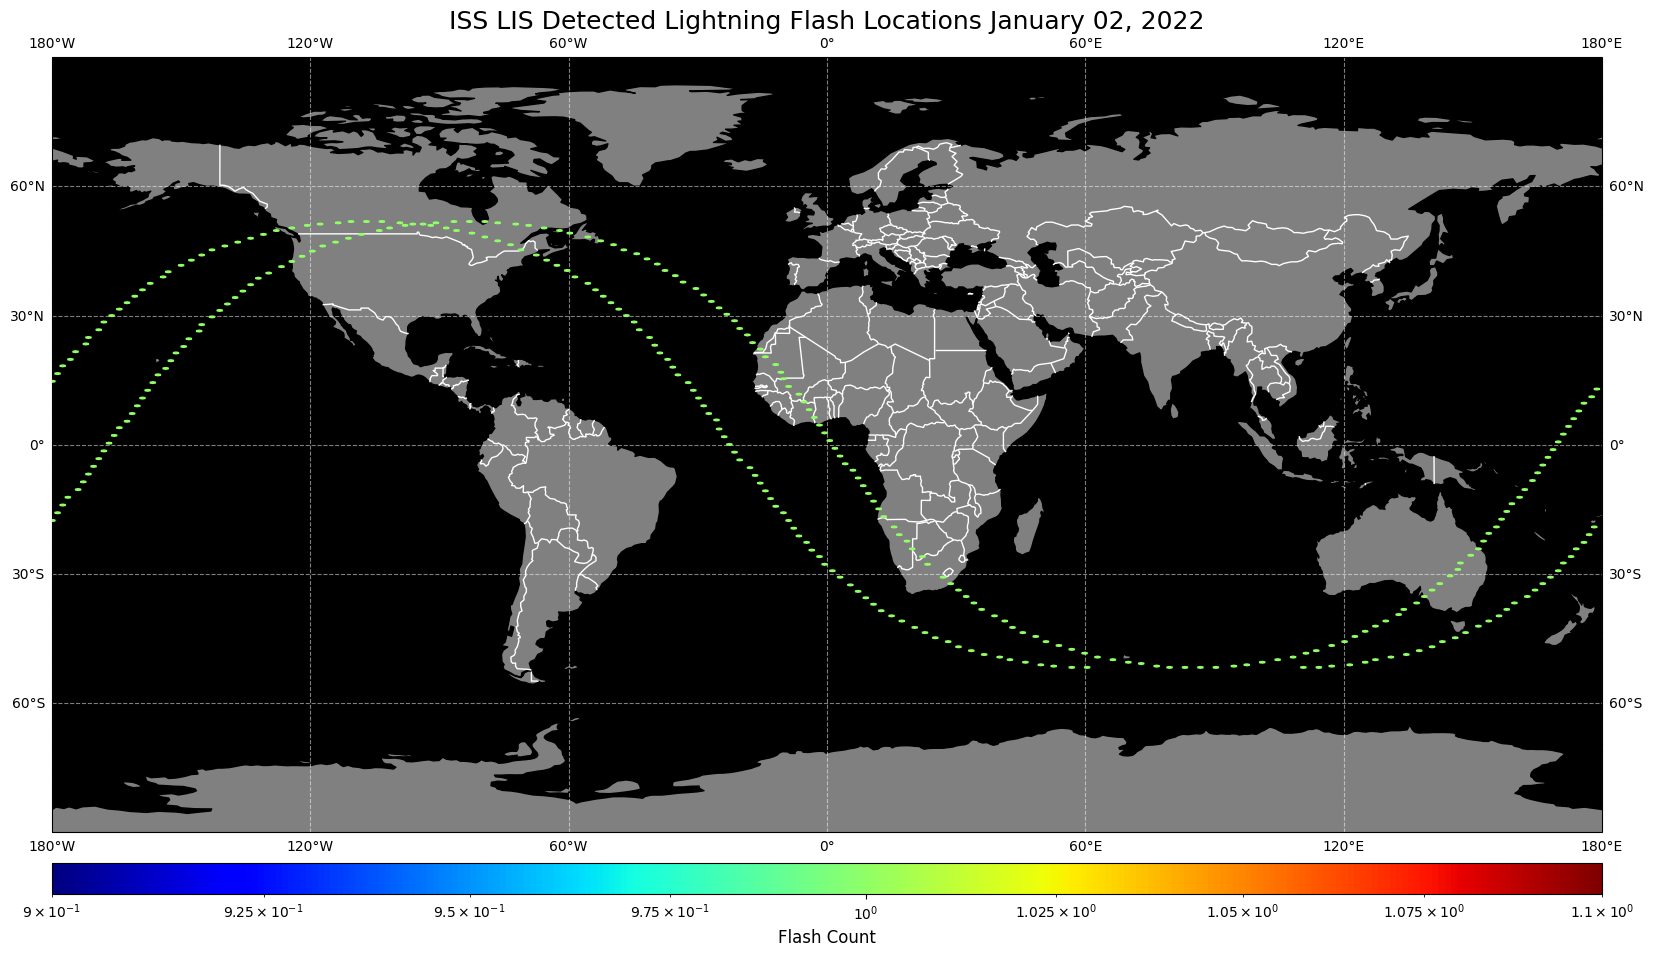

In [39]:
if file_count != 0:
    visualize(folder_name)

<span style="font-family: Arial, Helvetica, sans-serif; font-size: 16px; font-weight:bold">
    Removing the files from the local system.
<span>

In [40]:
#remove the data from local system
import shutil

if file_count != 0:
    shutil.rmtree(folder_name)